Clase 8
===

Objetivos

* Introducción a dFBA
* Resolución de ODEs con scipy.

Aprenderás a aplicar FBA bajo las condiciones dinámicas de cultivos por lote. En FBA dinámico (en adelante dFBA por su acrónimo en inglés: dynamic FBA) la evolución de la concetración de los metabólitos intracelulares durante la fermentación modifica las restricciones del FBA, cuyo resultado a su vez modifica los flujos de consumo y producción de las ecuaciones cinéticas.

Introducción a dFBA
----------------------

En un cultivo por lotes en donde puede haber alimentación.

<img src="https://raw.githubusercontent.com/modcommet/Clases/master/clase10_reactor.png" alt="Drawing" style="width: 200px;"/>

la biomasa aumenta, los sustratos se consumen, y los productos se acumulan. El siguiente gráfico corresponde a las variaciones del sustrato limitante (**Glu**:Glucosa), biomasa (**X**), y producto (**Eth**:Etanol) en un cultivo por lote alimentado de *Saccharomyces cerevisiae*. 

<img src="https://raw.githubusercontent.com/modcommet/Clases/master/clase10_cinetica.png" alt="Drawing" style="width: 500px;"/>

Matematicamente podemos reprentar este comportamiento dinámico realizando balances de masa a cada compuesto de interes. En nuestro ejemplo, **el modelo dinámico** es:

\begin{align}
\frac{dV}{dt} &=   F \\
\frac{dVX}{dt} &=\mu (VX) \\
\frac{dVGlu}{dt} &=F Glu_F-v_{Glu} MW_{Glu} (VX) \\
\frac{dVEth}{dt} &=v_{Eth} MW_{Eth} (VX) \\
\frac{dVGly}{dt} &=v_{Gly} MW_{Gly} (VX) \\
\frac{dVCit}{dt} &=v_{Cit} MW_{Cit} (VX) \\
\frac{dVLac}{dt} &=v_{Lac} MW_{Lac} (VX)] 
\end{align}

En donde los **flujos metabólicos** tanto de producción de biomasa ($\mu$) como de metabolitos ($v_{Eth}, v_{Gly}, v_{Cit}, v_{Lac}$) son computados por FBA:

\begin{align}
\mbox{max}\ & c^Tv \\
\mbox{s.a.} & \\
&\ Av=0 \\
&\ LB<=v<=UB
\end{align}

Como FBA está parametrizado en base al flujo de sustrato limitante, debemos definir una **cinética** para este último. Esto nos permitirá calcular valores de $v_Glu$ en función de las condiciones del medio de cultivo. Por ejemplo, [Sanches et al](http://www.sciencedirect.com/science/article/pii/S1096717614000950) modelaron $v_Glu$ con una expresion de tipo Monod, en la cual hay inhibición por etanol:


\begin{align}
v_{Glu}&=v_{Gmax}\left( \frac{Glu}{Glu+K_{Glu}} \right) \left( \frac{K_{Eth}}{Eth+K_{Eth}} \right)
\end{align}

Implementación en python
----------------------------

Podemos pensar en los componentes **dinámico**, **metabólico** y **cinético** de manera modular, definidos por funciones interdependientes entre si. Por ejemplo:


In [1]:
# Data based on:
# https://doi.org/10.1016/j.ymben.2014.07.004
# Libraries for the Dynamic block
import numpy as np
from scipy.integrate import odeint
# Libraries for the Metabolic block
import cobra
import os
from os.path import join
data_dir="."
#model=cobra.io.read_sbml_model(join(data_dir, "iMM904.xml"))
model=cobra.io.load_matlab_model("iDT1278.mat")
# Plotting libraries
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '((Avin_11760) and (Avin_13240) and (Avin_02950)) or ((Avin_45310) or (Avin_42560)' for <Reaction MPTG at 0x7f8226811460>
  warn("malformed gene_reaction_rule '%s' for %s" % (new_rule, repr(self)))
/usr/local/lib/python3.8/dist-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '((Avin_11760) and (Avin_13240) and (Avin_02950)) or ((Avin_45310) or (Avin_42560)' for <Reaction MPTG2 at 0x7f82267feb80>
  warn("malformed gene_reaction_rule '%s' for %s" % (new_rule, repr(self)))


In [2]:
# Kinetic block
def kineticBlock(Glu,Eth):
    # Parameters
    vGmax, K_Glu, K_Eth = 22.5, 0.88, 6.74
    f_Eth,f_Gly, f_Cit, f_Lac = .112, .273, .169, .137
    v_Glu=vGmax*Glu/(K_Glu+Glu)*1/(1+Eth/K_Eth)
    LB_Eth = -v_Glu*f_Eth
    LB_Gly = -v_Glu*f_Gly
    LB_Cit = -v_Glu*f_Cit
    LB_Lac = -v_Glu*f_Lac
    #LB_ATP_Ex = m_ATP
    return [v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac]

# Metabolic block
def metabolicBlock(v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac):
    model.reactions.get_by_id("EX_glc__D_e").lower_bound = -v_Glu # set flux of glucose
    model.reactions.get_by_id("EX_glc__D_e").upper_bound = -v_Glu # set flux of glucose
    model.reactions.get_by_id("EX_etoh_e").lower_bound   = LB_Eth
    model.reactions.get_by_id("EX_glyc_e").lower_bound   = LB_Gly
    model.reactions.get_by_id("EX_cit_e").lower_bound    = LB_Cit
    model.reactions.get_by_id("EX_lac__D_e").lower_bound = LB_Lac
    # The same for Eth, Gly, Cit, Lac
    solution = model.optimize()
    u = solution.objective_value
    v_Eth = model.reactions.get_by_id("EX_etoh_e").x
    v_Gly = model.reactions.get_by_id("EX_glyc_e").x
    v_Cit = model.reactions.get_by_id("EX_cit_e").x
    v_Lac = model.reactions.get_by_id("EX_lac__D_e").x
    return [u, v_Eth, v_Gly, v_Cit, v_Lac]
    
# Dynamic block
def f(y,t,params):
    V,VX,VGlu,VEth,VGly,VCit,VLac = y # Current values
    F,u, v_Glu, v_Eth, v_Gly, v_Cit, v_Lac = params  # unpack parameters
    Glu_F = 200
    MW_Glu,MW_Eth,MW_Gly,MW_Cit,MW_Lac = [0.18,.046,.092,.192,.090] #Molecular weights
    derivs=[F,                  # dV/dt
            u*VX,                # dVX/dt
            F*Glu_F-v_Glu*MW_Glu*(VX), # dVGlu/dt
            v_Eth*MW_Eth*(VX), # dVEth/dt
            v_Gly*MW_Gly*(VX), # dVGly/dt
            v_Cit*MW_Cit*(VX), # dVCit/dt
            v_Lac*MW_Lac*(VX)] # dVLac/dt
    return derivs
def dynamicBlock(y,params, ti,tf):
    time=np.linspace(ti,tf,100)
    #F,u,v_Glu, v_Eth, v_Gly, v_Cit, v_Lac = params
    soln = odeint(f,y,time,args=(params,))
    # Get solutions at the final time point (tf):
    V=soln[-1,0]
    X,Glu,Eth,Gly,Cit,Lac=soln[-1,1:7]/V
    return [V,X,Glu,Eth,Gly,Cit,Lac]    


# Save results along the fermentation path
u_path,V_path,X_path = [],[],[]
Glu_path,Eth_path,Gly_path,Cit_path,Lac_path = [],[],[],[],[]
v_Glu_path=[]
def savePath(u,V,X,Glu,Eth,Gly,Cit,Lac,v_Glu):
    global u_path,V_path,X_path
    global Glu_path,Eth_path,Gly_path,Cit_path,Lac_path
    global v_Glu_path
    u_path += [u]
    V_path += [V]
    X_path += [X]
    Glu_path += [Glu]
    Eth_path += [Eth]
    Gly_path += [Gly]
    Cit_path += [Cit]
    Lac_path += [Lac]
    v_Glu_path += [v_Glu]

In [3]:
# Initial conditions
Glu=20
Eth,Gly,Cit,Lac=[0,0,0,0]
V,X=[0.5,0.5]
F=0.5

# Running the simulation over time
time=np.linspace(0,50,600)
for i in range(len(time)):
    # KINETIC BLOCK: 
    # given the current concentrations of glucose (Glu) and ethanol (Eth)
    # we compute the fluxes of Glu, and upper and lower limits of Eth, Glycerol(Gly), Citrate(Cit), and Lactate(Lac)
    v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac = kineticBlock(Glu,Eth)
    # METABOLIC BLOCK
    # given v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac
    # we compute biomass growth rate (u) and metabolic fluxes of extracellular metabolites
    u,v_Eth, v_Gly, v_Cit, v_Lac = metabolicBlock(v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac)
    # DYNAMIC BLOCK
    # given u, V, fluxes (v_Eth, v_Gly, v_Cit, v_Lac), and concentrations (X,Glu,Eth,Gly,Cit,Lac)
    # we update reaction volume V, X and Glu,Eth,Gly,Cit,Lac
    if i==len(time)-1: continue
    y = [V,X*V,Glu*V,Eth*V,Gly*V,Cit*V,Lac*V]
    params = [F,u,v_Glu, v_Eth, v_Gly, v_Cit, v_Lac]
    V,X,Glu,Eth,Gly,Cit,Lac = dynamicBlock(y, params, time[i],time[i+1])
    # Save results along the fermentaion path
    savePath(u,V,X,Glu,Eth,Gly,Cit,Lac,v_Glu)

ValueError: The lower bound must be less than or equal to the upper bound (-22.3801197771469 <= -22.38012544310772).

Ejercicios
------------

1. Grafica los perfiles de concentración de biomasa glucosa, y etanol a lo largo del tiempo de fermentación.
2. Repite los resultados anteriores pero esta vez bajo las siguientes condiciones: Glu_0=5,Glu_F=300 y Glu_0=5,Glu_F=100
3. Transforma tu código en un scrip y subelo a tu cuenta de github.

In [ ]:
plt.plot(time[1:600],Glu_path,'r',linewidth=2,label='Glu')
plt.plot(time[1:600],X_path,'b',linewidth=2,label='X')
plt.plot(time[1:600],Eth_path,'g',linewidth=2,label='Eth')
plt.legend()
plt.ylabel('Biomass, Glucose & Ethanol [g/L]')
plt.xlabel('Time [h]')
plt.show()

In [ ]:
model

In [ ]:
# Let's modify the ethanol flux
# First, lets find the reactions associated with ethanol
import re

def buscarMetabolito(nombreMetabolite):
    metabolites=[]
    for metabolite in model.metabolites:
        if re.search(nombreMetabolite,metabolite.name,re.IGNORECASE):# and re.match("_e",metabolite.name): 
            metabolites.append(metabolite)
    if len(metabolites)==0:
        print( "Not found metabolite" )
        return None
    else: #print "2 lets find the reactions associated with the name"
        for metabolite in metabolites:
            print( "==================================")
            print( metabolite.name, metabolite.id)
            for reaction in model.metabolites.get_by_id(metabolite.id).reactions:
                print( reaction )
                
                
result=buscarMetabolito("cresol")

In [ ]:
model.medium

In [ ]:
solution=model.optimize()
model.summary()

In [ ]:
# Data based on:
# https://doi.org/10.1016/j.ymben.2014.07.004
# Libraries for the Dynamic block
import numpy as np
from scipy.integrate import odeint
# Libraries for the Metabolic block
import cobra
import os
from os.path import join
data_dir="."
#model=cobra.io.read_sbml_model(join(data_dir, "iMM904.xml"))
model=cobra.io.load_matlab_model("iDT1278.mat")
# Plotting libraries
import matplotlib.pyplot as plt

In [8]:
# Kinetic block
def kineticBlock(Glu):
    # Parameters
    vGmax, K_Glu = 22.5, 0.88 # This may be updated to the specific case of Azotobacter vineldii
    v_Glu=vGmax*Glu/(K_Glu+Glu)
    #LB_ATP_Ex = m_ATP
    return v_Glu

# Metabolic block
def metabolicBlock(v_Glu):
    print(v_Glu)
    model.reactions.get_by_id("EX_glc__D_e").bounds = (-v_Glu,-v_Glu) # set flux of glucose
    #model.reactions.get_by_id("DM_4crsol_c").lower_bound   = LB_4crsol
    #model.reactions.get_by_id("DM_5drib_c").lower_bound   = LB_5drib
    #model.reactions.get_by_id("DM_amob_c").lower_bound    = LB_amob
    # The same for Eth, Gly, Cit, Lac
    solution = model.optimize()
    u = solution.objective_value
    v_4crsol = model.reactions.get_by_id("DM_4crsol_c").x
    v_5drib = model.reactions.get_by_id("DM_5drib_c").x
    v_amob = model.reactions.get_by_id("DM_amob_c").x
    return [u, v_4crsol, v_5drib, v_amob]
    
# Dynamic block
def f(y,t,params):
    V,VX,VGlu,V4crsol,V5drib,Vamob = y # Current values
    F,u, v_Glu, v_4crsol, v_5drib, v_amob = params  # unpack parameters
    Glu_F = 200
    #This may be updated to the specific case of Azotobacter vineldii    
    MW_Glu,MW_4crsol, MW_5drib, MW_amob = [0.18,.046,.092,.192] #Molecular weights, 
    derivs=[F,                  # dV/dt
            u*VX,                # dVX/dt
            F*Glu_F-v_Glu*MW_Glu*(VX), # dVGlu/dt
            v_4crsol*MW_4crsol*(VX), # dV4crsol/dt
            v_5drib*MW_5drib*(VX), # dV5drib/dt
            v_amob*MW_amob*(VX)] # dVamob/dt
    return derivs
def dynamicBlock(y,params, ti,tf):
    time=np.linspace(ti,tf,100)
    #F,u,v_Glu, v_Eth, v_Gly, v_Cit, v_Lac = params
    soln = odeint(f,y,time,args=(params,))
    # Get solutions at the final time point (tf):
    V=soln[-1,0]
    x=soln[-1,1:6]
    ## if sum(x<0)>=1: break
    X,Glu,M4crsol,M5drib,Mamob=x/V
    return [V,X,Glu,M4crsol,M5drib,Mamob]    


# Save results along the fermentation path
u_path,V_path,X_path = [],[],[]
Glu_path,M4crsol_path,M5drib_path,Mamob_path = [],[],[],[]
v_Glu_path=[]
def savePath(u,V,X,Glu,M4crsol,M5drib,Mamob,v_Glu):
    global u_path,V_path,X_path
    global Glu_path,M4crsol_path,M5drib_path,Mamob_path
    global v_Glu_path
    u_path += [u]
    V_path += [V]
    X_path += [X]
    Glu_path += [Glu]
    M4crsol_path += [M4crsol]
    M5drib_path += [M5drib]
    Mamob_path += [Mamob]
    v_Glu_path += [v_Glu]

In [9]:
# Initial conditions
Glu=20
M4crsol,M5drib,Mamob=[0,0,0]
V,X=[0.5,0.5]
F=2

# Running the simulation over time
time=np.linspace(0,30,600)
for i in range(len(time)):
    # KINETIC BLOCK: 
    # given the current concentrations of glucose (Glu) and ethanol (Eth)
    # we compute the fluxes of Glu, and upper and lower limits of Eth, Glycerol(Gly), Citrate(Cit), and Lactate(Lac)
    v_Glu = kineticBlock(Glu)
    # METABOLIC BLOCK
    # given v_Glu,LB_Eth,LB_Gly,LB_Cit,LB_Lac
    # we compute biomass growth rate (u) and metabolic fluxes of extracellular metabolites
    u, v_4crsol, v_5drib, v_amob = metabolicBlock(v_Glu)
    # DYNAMIC BLOCK
    # given u, V, fluxes (v_Eth, v_Gly, v_Cit, v_Lac), and concentrations (X,Glu,Eth,Gly,Cit,Lac)
    # we update reaction volume V, X and Glu,Eth,Gly,Cit,Lac
    if i==len(time)-1: continue
    y = [V,X*V,Glu*V,M4crsol*V,M5drib*V,Mamob*V]
    params = [F,u,v_Glu, v_4crsol, v_5drib, v_amob]
    V,X,Glu,M4crsol,M5drib,Mamob = dynamicBlock(y, params, time[i],time[i+1])
    # Save results along the fermentaion path
    savePath(u,V,X,Glu,M4crsol,M5drib,Mamob,v_Glu)

21.551724137931036
22.110541473733573
22.225860179670228
22.275657754368382
22.303420377724784
22.321123190505045
22.3333947898097
22.342401807130237
22.349293696877965
22.35473695844644
22.359144673641488
22.36278649516533
22.36584592572424
22.368452177763874
22.37069886819772
22.372655485882674
22.374374694201734
22.375897132790787
22.377254663647292
22.378472619470028
22.37957139459605
22.380567592372014
22.38147486683428
22.382304549676455
22.38306612380031
22.383767585531086
22.38441572488411
22.385016344727152
22.3855744338359
22.386094304775657
22.386579704676645
22.387033904922596
22.387459774291678
22.387859839005248
22.388236332339414
22.388591235856104
22.388926313860107
22.389243142345805
22.389543133434955
22.3898275561042
22.390097553843216
22.390354159761
22.390598309560378
22.390830852723653
22.391052562190584
22.391264142760644
22.391466238411404
22.391659438692777
22.391844284330404
22.392021272150014
22.392190859416772
22.39235346766916
22.392509486114733
22.39265927

6.852311868508892
0.0
6.833996652860153
0.0
6.815779083939479
0.0
6.79765838292249
0.0
6.7796337792493135
0.0
6.7617045105079585
0.0
6.743869822331861
0.0
6.726128968292393
0.0
6.708481209793396
0.0
6.6909258159710285
0.0
6.673462063592508
0.0
6.656089236955494
0.0
6.638806627791936
0.0
6.621613535166874
0.0
6.604509265392964
0.0
6.587493131928534
0.0
6.570564455290399
0.0
6.553722562962389
0.0
6.536966789304006
0.0
6.520296475465688
0.0
6.503710969304085
0.0
6.487209625289477
0.0
6.470791804431198
0.0
6.454456874188275
0.0
6.4382042083921265
0.0
6.422033187165553
0.0
6.405943196841338
0.0
6.389933629889492
0.0
6.374003884837538
0.0
6.358153366194868
0.0
6.342381484381109
0.0
6.3266876556481995
0.0
6.31107130201643
0.0
6.295531851195086
0.0
6.280068736515463
0.0
6.264681396866467
0.0
6.249369276620014
0.0
6.234131825566048
0.0
6.2189684988518
0.0
6.203878756907848
0.0
6.18886206539341
0.0
6.173917895124005
0.0
6.159045722018216
0.0


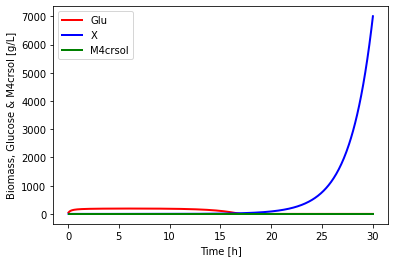

In [7]:
plt.plot(time[1:600],Glu_path,'r',linewidth=2,label='Glu')
plt.plot(time[1:600],X_path,'b',linewidth=2,label='X')
plt.plot(time[1:600],M4crsol_path,'g',linewidth=2,label='M4crsol')
plt.legend()
plt.ylabel('Biomass, Glucose & M4crsol [g/L]')
plt.xlabel('Time [h]')
plt.show()

In [15]:
x=np.array([10,1,-2])
x<0
x

array([10,  1, -2])

In [16]:
sum(x<0)

1